In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torchvision.transforms.functional as TF

from src.datasets import MyDataset
from utils.helper import visualize_dataset
from utils.config import WorldStrat_path, DEVICE
from torch.utils.data import DataLoader
from models.network_swinir import SwinIR

print(f'Dvice: {DEVICE}')
dataset = MyDataset(WorldStrat_path)
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

Dvice: cpu


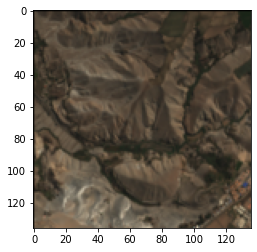

In [16]:

plt.imshow(dataset[10][1].permute(1, 2, 0).numpy())


In [5]:
upscale = 4
window_size = 8
height = (500 // upscale // window_size + 1) * window_size
width = (500 // upscale // window_size + 1) * window_size
model = SwinIR(upscale=8, img_size=(height, width),
                window_size=window_size, img_range=1., depths=[6, 6, 6, 6],
                embed_dim=60, num_heads=[6, 6, 6, 6], mlp_ratio=2, upsampler='pixelshuffledirect')

model.to(DEVICE)
model.load_state_dict(torch.load("model_zoo/model.pth", map_location=DEVICE))

<All keys matched successfully>

In [3]:
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


def train(epochs, model, dataloader, criterion, optimizer, device, save_path=None):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(dataloader):
            hr, lr = batch
            hr, lr = hr.to(device), lr.to(device)
            optimizer.zero_grad()
            output = model(lr)
            loss = criterion(output, hr)
            loss.backward()
            optimizer.step()
            del loss
            del output
            del hr
            del lr

        print(f'epoch: {epoch}, loss: {total_loss / len(dataloader)}')
        if save_path is not None:
            torch.save(model.state_dict(), save_path)

train(100, model, train_loader, criterion, optimizer, DEVICE, save_path='model_zoo/swinir.pth')

100%|██████████| 900/900 [04:33<00:00,  3.29it/s]


epoch: 0, loss: 0.0


 18%|█▊        | 162/900 [01:16<1:07:12,  5.46s/it]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


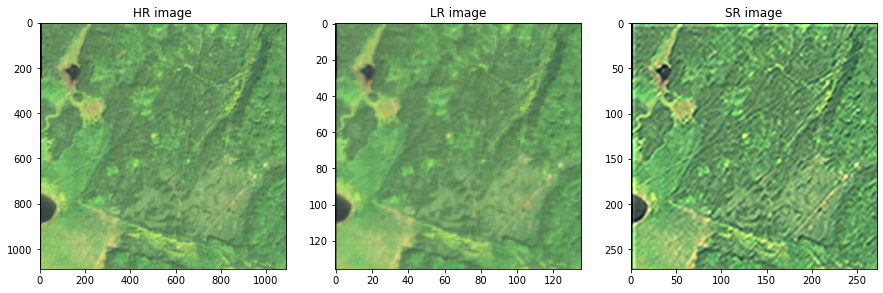

In [17]:
for batch in train_loader:
    hr, lr = batch
    hr = hr.to(DEVICE)
    lr = lr.to(DEVICE)
    res = model(lr)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(hr[0].permute(1, 2, 0).cpu().numpy())
    ax[0].set_title('HR image')
    ax[1].imshow(lr[0].permute(1, 2, 0).cpu().numpy())
    ax[1].set_title('LR image')
    ax[2].imshow(res[0].permute(1, 2, 0).cpu().detach().numpy())
    ax[2].set_title('SR image')
    plt.show()
    break